### ⚠️ Warning: This page is still in a draft state. Information may be incorrect or incomplete and move around the page.

# Preface

This page is designed to be a debbie-downer and try to answer the question
> My model is so great.. but why? 👀

Sometimes we may be working on a problem. A model is created and evaluated and the outcome is almost too good to believe. Sometimes it is. This page serves as a reference to commonly occurring problems in the data processing, modelling, and evaluation protocols that can lead to inflated performance.

This page is aimed at practitioners with a working knowledge of machine learning, usually enough to produce a frighteningly good model from a data set until it is deployed to the real-world.



## OPAI-1: Information Leakage
Data is typically split into two or more subsets before being modeled, commonly know as a train and test set. The training split of data is used to fit the learned function, while the test set is used to confirm the model has learned some generalisable function and not just memorised the inputs, known as overfitting.

Information leakage can occur during any stage of the modeling process from data collection and preparation through to training and evaluation. __It occurs when the model has access to more information at the point of development and evaluation than during its deployment on out of sample data in production__. This additional information can allow the model to have knowledge of something that it otherwise would not have access to at inference time and in turn invalidates the estimated performance of the model being constructed. In abstract terms, this can be viewed as an open-book exam. Information leakage typically results in overly optimistic expectations of model performance; thus it is characterised by poor performance on out-of-sample datasets, i.e. when the model is put to use in production environments.

The most fundamental example of data leakage would be if the target values of a dataset are included as an input to the model. For example, if the label or regression target of a dataset are included in the set of input features used to predict themselves. This is an unambiguous example of information leakage between the input and output values of a data sample. 

### OPAI-1.1: Data collection

#### OPAI-1.1.1:  Process artefacts
Often, information leakage can be much more subtle than directly including the target in the model input. Information about the target can be leaked from the input sample through errant data collection and curation practises. For example, during the ICML 2013 Whale Challenge [a competitor found](https://www.kaggle.com/c/the-icml-2013-whale-challenge-right-whale-redux/discussion/4865) that the dataset provided for the competition was leaking information in the training set. Christopher Hefele
found that 
 - Certain file sizes provided a strong indication that a clip had a whale upcall in it - files with whale upcalls were larger, on average.  
 - If a whale upcall was not in a file, the millisecond field in the timestamp was almost always a multiple of 10 ms  (see this)
 - If a whale upcall was in a file, the millisecond field seemed evenly distributed in time
 - The  timestamp embedded in the audio clip filename (focusing mostly on the millisecond field)
 - The chronological order of the clips contained information. A moving average of clip labels in the training set showed a pattern: minutes or hours of high whale-call activity, followed by equally lengthy lulls.
    
This an example of information leakage because when the model is deployed to production and used with data in the wild, the clips will likely not be so curated.

#### OPAI-1.1.2: Duplicate data
Real-world datasets are often imperfect and can contain duplicate data. If left in the dataset, these can be split into the training, test, and validation sets. This results in the model training and testing on the same data. Sometimes, due to noise in the data there may also be near identical samples which can cause the same problem if they represent a large portion of the dataset.

#### OPAI-1.1.2:  Point in time correctness
Data can evolve over time. So if we use some snapshot of the data at some point in time, the model will learn how to create predictions for data at that stage of its lifecycle and perform worse on times before and after. What that snapshot does not show is the succession of mutations applied to the data before it reached the state at which it was exported and used to create a predictive model.

This can be demonstrated when collecting profiles of users. For example, when creating a model to predict the default rate of loan applications, a financial institution may use a snapshot export of a database of real customers. Within the dataset, there is a feature describing the number of late payments for a given customer. This number will change over time. If the model focuses on that number, then it may perform poorly on loans early in their life due to the lack of accumulated data. Therefore, if we train and evaluate our model on a dataset that contains more observations per sample than that on which it creates inferences on in production, this will cause an overestimate of performance of the model unless it is also deployed on data collected at the same stage in the loan.






### OPAI-1.2: Dataset Preperation

#### OPAI-1.2.1: Direct leakage / Leaky targets
The simplest form of information leakage during data set preparation can occur by directly leaking the target variable into the feature set, for example, by including the label within the set of features fed to the model to learn from. This can happen by not dropping the target columns during data set preparation.

#### OPAI-1.2.2: Data Cleaning

When working with datasets of real-world origin, practitioners often encounter corrupted or completely missing data. This usually occurs with Tabular datasets that have missing data and require data imputation. In such instances, it is common to attempt to rescue the corrupted samples by imputing missing values using descriptive measures over the remaining non-missing values such as mean, median, or mode values for that feature. These data cleaning steps are typically non-problematic when applied with care. The issues arise when imputation of missing values is performed using the entire dataset, _prior_ to splitting into subsets for training, test, and validation. This is because information about the testing data will “leak” into the training data and vice-versa. Test data should be out of the sample so this is a problem. The real-world performance difference here is typically negligible if the data has been collected well because the train and test data should not be of materially different distributions. However, this represents a failure in protocol which is never a good thing and can lead to larger errors overall. Not to mention that a negligible performance boost could be the difference between SOTA performance and regular performance.


#### OPAI-1.2.3: Feature engineering
The same can be true when transforming raw source data into features for your model by cleaning or by extraction such as getting the mean of points, for example, if you have a time series model. Say your data is in tabular format. You add a new feature column that applies a function with window size 4 and slide of 1. This feature now incorporates data from surrounding rows. If your data is in order and you are predicting t+n where n is within the window, you are now leaking future information into your data.

A clear rule to detection leakage during feature engineering is when features are derived as a function of the target variable(s). For example, if we create a model to predict the annual salary of an employee and create a feature to represent the monthly salary of the same employee.

More commonly, leaks can be far more nuanced. For example, training a model to predict the price of some stock at time t+1 while also supplying the traded volume at t+1 as part of the input set of data. This is information that will only be known at t+1 and therefore cannot be used to predict into the future from time t.

#### OPAI-1.2.2: Data augmentation
In computer vision tasks, it is commonplace to augment the training set with filters such as black&white, mirroring, cropping, rotation and so on, based on the task at hand. If the practitioner augments the entire dataset before splitting it, what may happen is that Sample (A) in the dataset has been expanded to _n_ derived examples with various augmentations applied. The dataset is then split randomly and the derived Samples of (A) are spread across the train/test/validation sets. This means the model has the opportunity to learn from Sample (A) in the training set and then evaluate its performance on a copy of the same. This naturally can lead to a circumstance of inflated performance during evaluation.

#### OPAI-1.2.2: Sampling 
Duplicate rows between train/validation/test (e.g. oversampling a dataset to pad its size before splitting; e.g. different rotations/augmentations of a single image; bootstrap sampling before splitting; or duplicating rows to up sample the minority class)


#### OPAI-1.2.4: Scaling data / Data transforms

Commonly, data input to a machine learning model must be scaled. If this is performed prior to splitting the data, we will leak information about the test and validation sets to the training set. The test and validation sets should be analogous to data that is collected from the wild.

Most importantly, we are using information from data that will appear in both the test and training data. This is because our mean and standard deviation will be based on the full dataset, not just the training data. Conversely, normalising the train and test sets separately is also incorrect, but at least not because of leakage. It is incorrect because the two operations will use different means and standard deviations which breaks the assumption that the data is drawn from the same distribution. It is also operationally inefficient - what mean and standard will you use in production for inference on hitherto unseen examples? Those of the train set, test set, or of the batch of data you are inferencing on? This could lead to worsened real-world performance.
 
The correct approach is to first perform the split of the dataset, then normalise the training set and finally apply the mean and standard deviation to the normalisation of the test set.




In [1]:
%%HTML
<pre class="mermaid">
    flowchart LR
        subgraph The right way
        direction LR  %%
        A[Source Dataset \n e.g. IRIS ]
        A --> B{fa:fa-spinner Random Split}
        B --> C(StandardScaler \nFit) --> |Mean and Std| X(StandardScaler \nTransform) --> Y[Train]
        C--> |Mean and Std| E
        B --> E(StandardScaler \nTransform) --> F[Test]
        C--> |Mean and Std| G
        B --> G(StandardScaler \nTransform) --> H[Validation]
        end
</pre>
<pre class="mermaid">
    flowchart LR
        subgraph The wrong way
        direction LR  %%
        A[Source Dataset \n e.g. IRIS] --> B(StandardScaler \nFit & Transform)
        B --> C{fa:fa-spinner Random Split}
        C --> D[Train]
        C --> E[Test]
        C --> F[Validation]
          end
</pre>

### OPAI-1.3: Incorrect use of shuffle 
#### OPAI-1.3.1: Temporal leakage through shuffling timeseries data
When building predictive models, we are interested in the performance of the model on data that was not used to train it - this gives us an idea of the real-world performance. Typically, we can gauge this performance on out of sample data points by using some variation of a train-test split protocol. The test set is used to gauge the performance of the model on unseen data as it would have access to in the final deployment environment. when constructing these subsets of data it is good practise to randomly shuffle the full dataset before splitting into the train and test sets. Shuffling our full dataset is only good practise when the dataset is independent and identically distributed (i.i.d.).

Time series data is assumed to be non-iid. When we shuffle data that is Non-i.d.d. we can cause information leakage because the shuffling of samples is only valid under the assumption that there is NO relationship between the observations. This is not true of time series data because it is a list of observations where the ordering matters. The effect of a random split is illustrated below. 

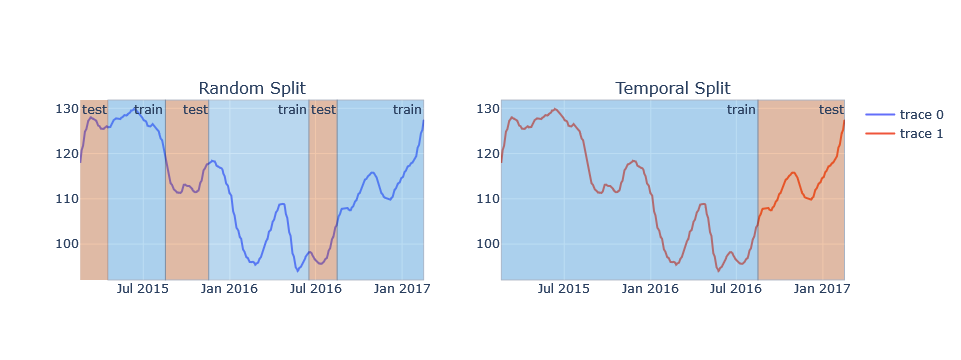

In [98]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv')
train_colour = "rgba(52, 152, 219, 1)"
test_colour = "rgba(211, 84, 0, 1)"

fig = make_subplots(rows=1, cols=2, subplot_titles=("Random Split", "Temporal Split"))
fig.add_trace(
    go.Scatter(
        x=df["Date"],
        y=df["mavg"],  
    ),
    row=1,
    col=1
)
fig.add_trace(
    go.Scatter(
        x=df["Date"],
        y=df["mavg"],
    ),
    row=1,
    col=2
) 

# add vrects to left plot
fig.add_vrect(
    x0="2015-02-17",
    x1="2015-04-17",
    row=1,
    col=1,
    annotation_text="test",
    annotation_position="top right",
    fillcolor=test_colour,
    opacity=0.33,
    line_width=0
)
fig.add_vrect(
    x0="2015-04-17",
    x1="2015-08-17",
    row=1,
    col=1,
    annotation_text="train",
    annotation_position="top right",
    fillcolor=train_colour,
    opacity=0.33,
    line_width=1
)
fig.add_vrect(
    x0="2015-08-17",
    x1="2015-11-17",
    row=1,
    col=1,
    annotation_text="test",
    annotation_position="top right",
    fillcolor=test_colour,
    opacity=0.33,
    line_width=1
)
fig.add_vrect(
    x0="2015-11-17",
    x1="2016-06-17",
    row=1,
    col=1,
    annotation_text="train",
    annotation_position="top right",
    fillcolor=train_colour,
    opacity=0.25,
    line_width=1
)
fig.add_vrect(
    x0="2016-06-17",
    x1="2016-08-16",
    row=1,
    col=1,
    annotation_text="test",
    annotation_position="top right",
    fillcolor=test_colour,
    opacity=0.33,
    line_width=1
)
fig.add_vrect(
    x0="2016-08-16",
    x1="2017-02-16",
    row=1,
    col=1,
    annotation_text="train",
    annotation_position="top right",
    fillcolor=train_colour,
    opacity=0.33,
    line_width=1
)


# add vrects to right plot
fig.add_vrect(
    x0="2015-02-17",
    x1="2016-08-16",
    row=1,
    col=2,
    annotation_text="train",
    annotation_position="top right",
    fillcolor=train_colour,
    opacity=0.33,
    line_width=1
)
fig.add_vrect(
    x0="2016-08-16",
    x1="2017-02-16",
    row=1,
    col=2,
    annotation_text="test",
    annotation_position="top right",
    fillcolor=test_colour,
    opacity=0.33,
    line_width=1
)

fig.show()

In the random split, we can see that in the training set there is future information available for the model to learn on, which strictly speaking the model would not have access to in a real-world scenario. For this reason, we must split our dataset into subsets while maintaining the temporal order in which values were observed. With simple data preparation protocols this is easy, simply ordering the data on the time axis and splitting. When we wish to introduce more complex training and validation protocols such as k-folds we can instead use the walk-forward validation method. The walk-forward protocol again respects the temporal order of the data but uses a subset of the data at a time. This is sometimes referred to as Out-of-Time Validation.

# Conclusion 

If something is too good to be true, it often is. But do not be discouraged! Every practitioner has made at least one of these errors so far. If you see one of these errors being made in the wild within you team, feel free to share a permalink to one of the `OPAI` headers to spark up debate about your specific situation.

Errors are unavoidable, to catch them is desireable.



# Contributing
This is an open-source living document. The source is hosted on this public github repository. If you have additions, corrections, questions, or anything in-between, please open an Issue or a Pull Request. All contributions are greatly appreciated!

# Glossary

**Timeseries**: A time series is a set of observations xt each one being recorded at a
specific time t. If a random variable X is indexed to time, usually denoted by t, the observations {Xt, t ∈ T} is
called a time series, where T is a time index set.

In [1]:
%%HTML

<script type="module">
  import mermaid from 'https://cdn.jsdelivr.net/npm/mermaid@10.1/dist/mermaid.esm.min.mjs';
  let config = { startOnLoad: true,  securityLevel: 'loose', htmlLabels:true, flowchart: { useMaxWidth: false, htmlLabels: true } };
  mermaid.initialize(config);
    mermaid.run({ htmlLabels:true,
  querySelector: '.mermaid',
});
    
// for live editing, re-render only the text of the current cell
    //window.IPython && $(IPython.events).on("RenderedMarkdown", function(evt, data){
        // this is using a hacked mermaid that accepts some nodes!
    //    mermaid.init(undefined, data.cell.element.find(".mermaid"));
    //});
    
    // let config = { startOnLoad: true, securityLevel: 'loose', flowchart: { useMaxWidth: false, htmlLabels: true } };
  // mermaid.initialize(config);   
    
</script>
<style>
    .mermaid *{font-family: sans-serif; }
    .mermaid .node, .mermaid .cluster{
      fill: white !important;
      stroke: black !important;
      stroke-width: 1px !important;
    }
    .mermaid div{
      text-align: center;
    }
    .mermaid .label{
      color: black;
    }
</style>
